<left>
    <h4>CNN + LSTM</h4>
</left>

---


=== Distribusi Kelas Setelah SMOTE ===
Class 0 (Diabetes): 2921
Class 1 (Non-diabetes): 2921
Class 2 (Prediabetes): 2921
Total data setelah SMOTE: 8763 sampel
Epoch 1/40


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4741 - loss: 1.0272 - val_accuracy: 0.6754 - val_loss: 0.7620
Epoch 2/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6865 - loss: 0.7033 - val_accuracy: 0.7165 - val_loss: 0.6412
Epoch 3/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7296 - loss: 0.6033 - val_accuracy: 0.7245 - val_loss: 0.6204
Epoch 4/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7389 - loss: 0.5834 - val_accuracy: 0.7370 - val_loss: 0.5797
Epoch 5/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7533 - loss: 0.5614 - val_accuracy: 0.7741 - val_loss: 0.5359
Epoch 6/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7738 - loss: 0.5252 - val_accuracy: 0.8015 - val_loss: 0.5118
Epoch 7/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7992 - loss: 0.4948 - val_accuracy: 0.7422 - val_loss: 0.5660
Epoch 8/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8101 - loss: 0.4721 - val_accuracy: 0.8346 - va

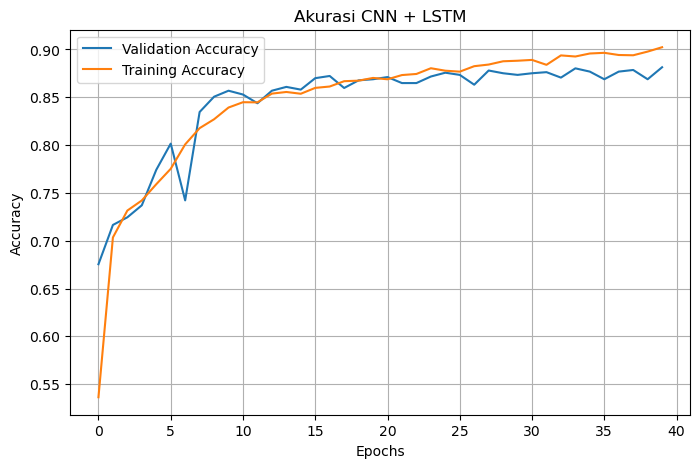

In [2]:
# =============================================
# 🧩 CNN + LSTM (Baseline)
# =============================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- 1. Load data ---
df = pd.read_csv("../Dataset/data_scaled_clean.csv", delimiter=";")

# --- 2. Cleaning ---
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# --- 3. Fitur dan Label ---
X = df.drop(columns=['status', 'hba1c', 'berat', 'tinggi'])
y = df['status']

# --- 4. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 5. SMOTE Oversampling ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("\n=== Distribusi Kelas Setelah SMOTE ===")
unique, counts = np.unique(y_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u} ({le.inverse_transform([u])[0]}): {c}")
print(f"Total data setelah SMOTE: {len(y_resampled)} sampel")

# --- 6. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- 7. Normalisasi ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 8. Reshape (samples, timesteps, features=1) ---
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

# --- 9. Bangun model CNN + LSTM ---
model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# --- 10. Compile ---
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- 11. Training ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=40, batch_size=32, verbose=1
)

# --- 12. Evaluasi ---
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n🎯 Akurasi Test: {acc:.4f}, Loss: {loss:.4f}")

# --- 13. Plot Akurasi ---
plt.figure(figsize=(8,5))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title("Akurasi CNN + LSTM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# =============================================
# ⚙️ CNN + LSTM Hyperparameter Tuning (Keras Tuner)
# =============================================
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    # Jumlah filter CNN
    model.add(Conv1D(
        filters=hp.Choice('filters', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size', [2, 3]),
        activation='relu',
        input_shape=(X_train_scaled.shape[1], 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    # LSTM layer pertama
    model.add(LSTM(hp.Choice('lstm_units1', [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout1', [0.2, 0.3, 0.4])))
    # LSTM layer kedua
    model.add(LSTM(hp.Choice('lstm_units2', [16, 32, 64])))
    # Dense layer
    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout2', [0.2, 0.3, 0.4])))
    # Output
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 1️⃣ Inisialisasi tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_lstm_tuning'
)

# --- 2️⃣ Jalankan pencarian ---
tuner.search(X_train_scaled, y_train, epochs=25, validation_data=(X_test_scaled, y_test), verbose=1)

# --- 3️⃣ Dapatkan model terbaik ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n=== Hyperparameter Terbaik ===")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# --- 4️⃣ Evaluasi akhir ---
loss, acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n🎯 Akurasi Model Terbaik: {acc:.4f}, Loss: {loss:.4f}")


Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.7895036935806274

Best val_accuracy So Far: 0.8910439014434814
Total elapsed time: 00h 10m 36s


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== Hyperparameter Terbaik ===
filters: 32
kernel_size: 2
lstm_units1: 64
dropout1: 0.3
lstm_units2: 64
dense_units: 128
dropout2: 0.4
lr: 0.01

🎯 Akurasi Model Terbaik: 0.8910, Loss: 0.3486
